## Setup

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

## Imports

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rich 
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn
from rich import print
from tpvalidator.utilities import temporary_log_level, pandas_backend


rich.get_console().is_jupyter = False


# Code

In [46]:

def draw_bt_eff_by_plane(ws, rop_id, ax, filter: str=None):
    rop_code = {
        0: 'U',
        1: 'V',
        2: 'X',
    }
    tot_nel_df = ws.event_summary[['event', f'tot_numelectrons_{rop_code[rop_id]}']].set_index('event')
    tps = ws.tps.query(f'bt_is_signal == 1 & readout_plane_id == {rop_id}')
    if filter:
        tps = tps.query(filter)
    bt_nel_df = pd.DataFrame(tps.groupby('event').bt_numelectrons.sum())
    eff_df = tot_nel_df.merge(bt_nel_df, how='inner', on='event').fillna(0)
    eff_df['ratio'] = eff_df.bt_numelectrons/eff_df[f'tot_numelectrons_{rop_code[rop_id]}']
    eff_df.ratio.hist(ax=ax)
    return eff_df

# Load ADC mean and standard deviation from wafevorm histograms

In [4]:
dataset_info = {
    'readout_window' : 8500
}

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/ar39/100events/trigtree_tpg_vd_ar39.root", extra_info=dataset_info)

print(ws.info)

INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 72540769 rows


None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 23,
            'threshold_tpg_plane1': 23,
            'threshold_tpg_plane2': 26,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

In [5]:
ws.add_rawdigits('../../data/vd/ar39/100events/trigger_digits_waves_detsim_vd_ar39.root')


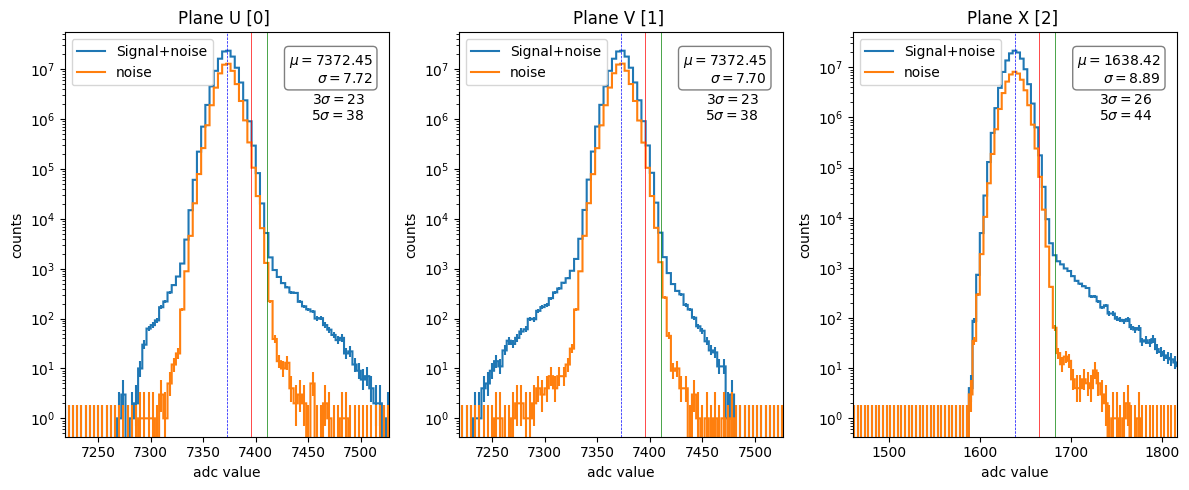

In [6]:
fig = snn.draw_signal_and_noise_adc_distros(ws)
fig.tight_layout()

# TP validation


In [33]:
all_tps = snn.TPSignalNoiseSelector(ws.tps)
alltp_ana = snn.TPSignalNoiseAnalyzer(all_tps, signal_name='Ar39')

## Distribution of point of origin in the detector

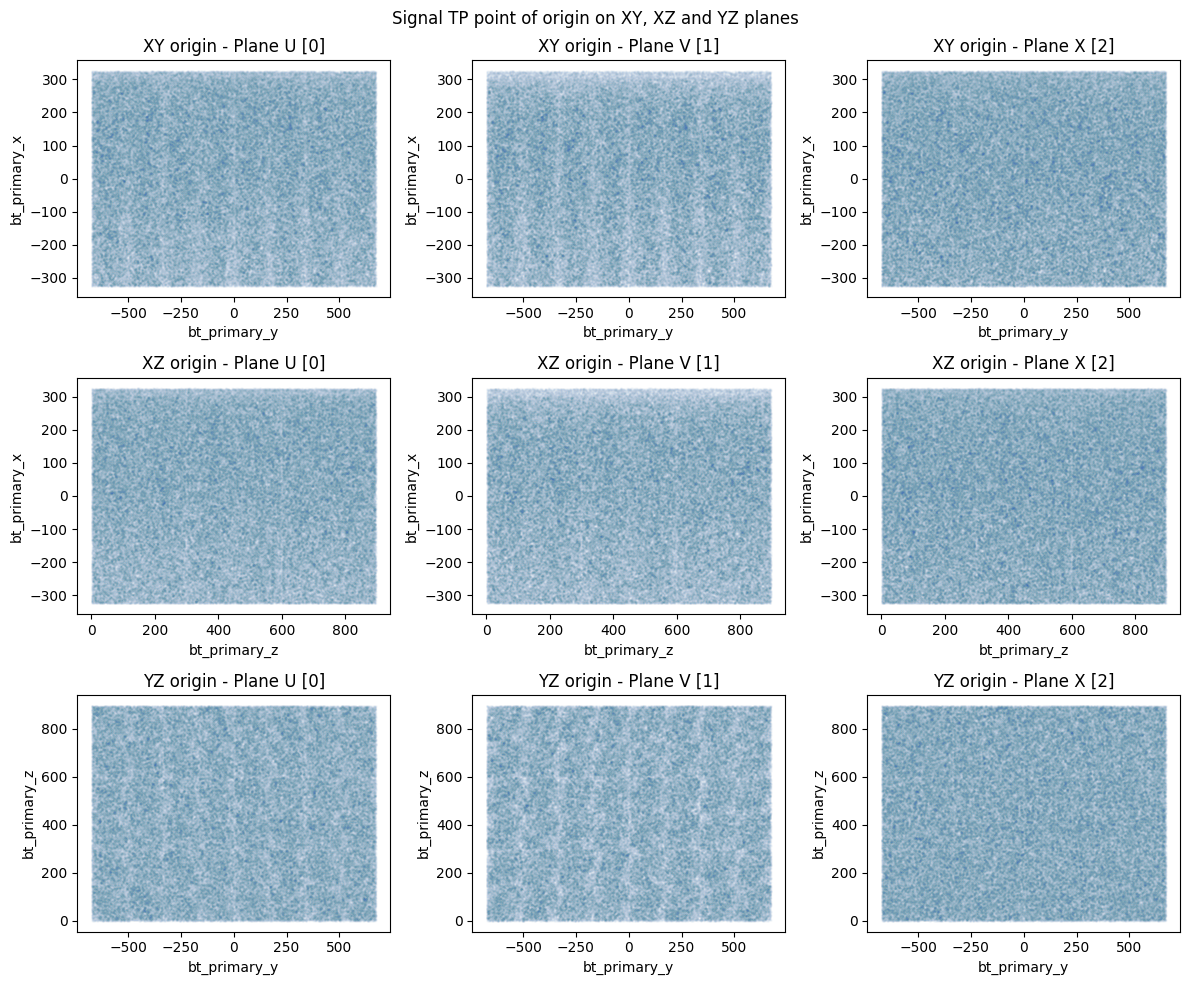

In [34]:
fig = alltp_ana.draw_tp_sig_origin_2d_dist()
fig.tight_layout()

In [35]:
pd.options.plotting.backend = 'plotly'
import plotly.express as px
# ws.tps.query('event == 1 & TP_peakADC > 50').plot.scatter(x='TP_channel', y='TP_peakT', size='TP_peakADC', color_continuous_scale=px.colors.sequential.Viridis, height=500, width=600)

pd.options.plotting.backend = 'matplotlib'
with pandas_backend('plotly') as x:
    f = ws.tps.query('event == 1 & readout_view==2').plot.scatter(x='channel', y='sample_start', size='adc_peak', color="bt_is_signal", color_continuous_scale=px.colors.sequential.Viridis, height=800, width=900)
    f.show()


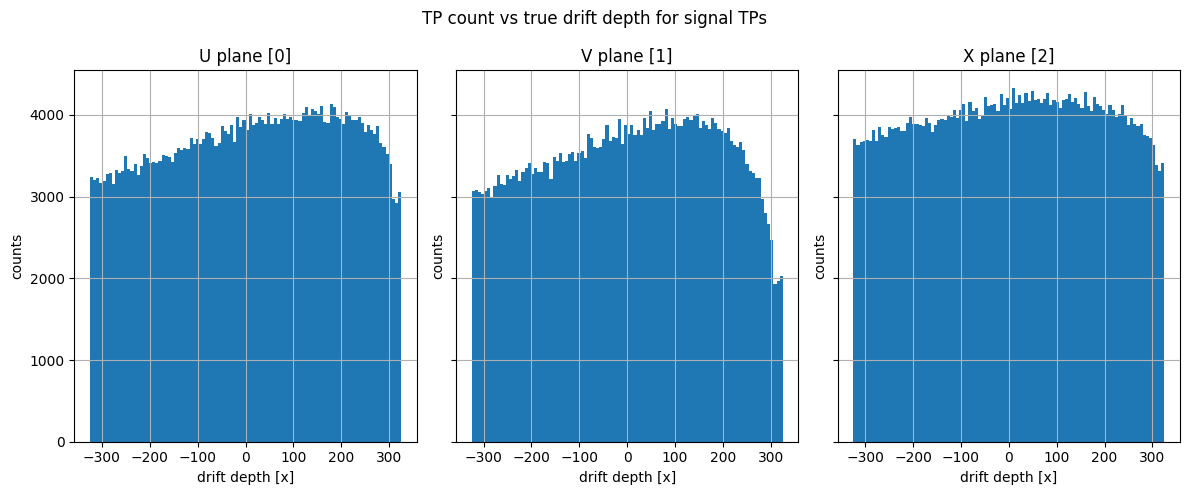

In [36]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist()

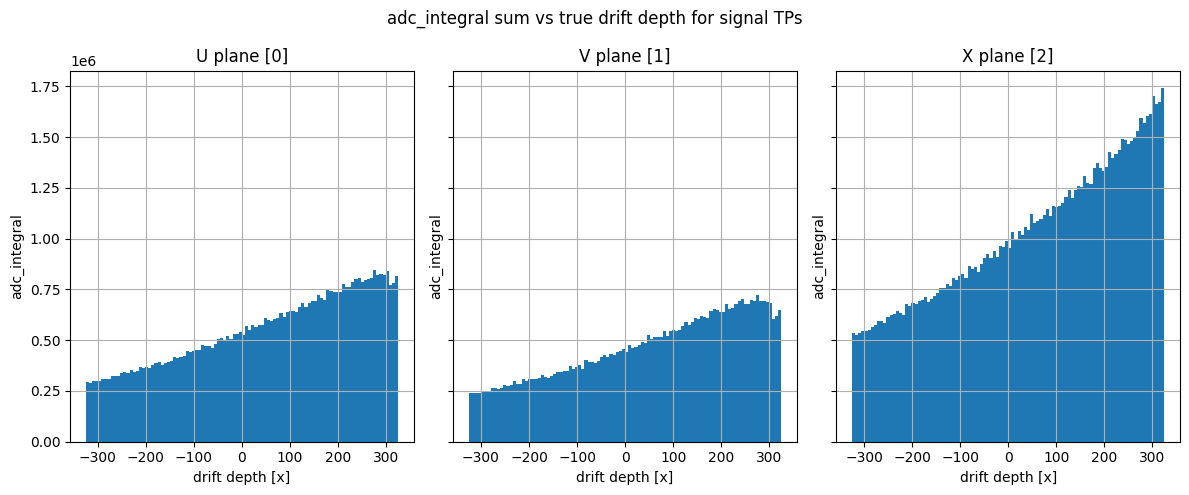

In [37]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist(weight_by='adc_integral')

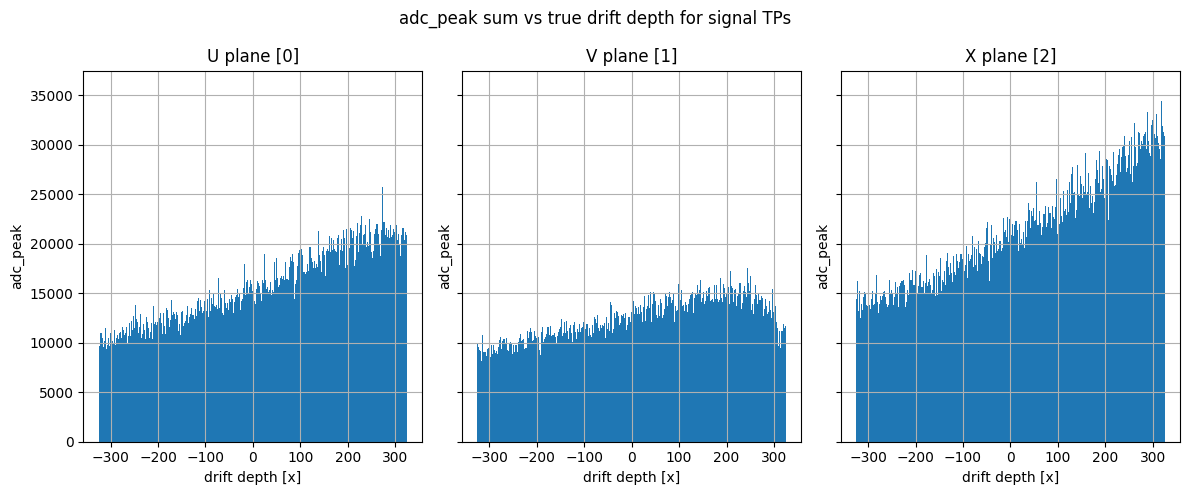

In [38]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist(weight_by='adc_peak', bins=1000)

# Dataset validation: TP distributions

### Signal and noise TP distribution in channel and time - one event with increasing peak ADC cuts

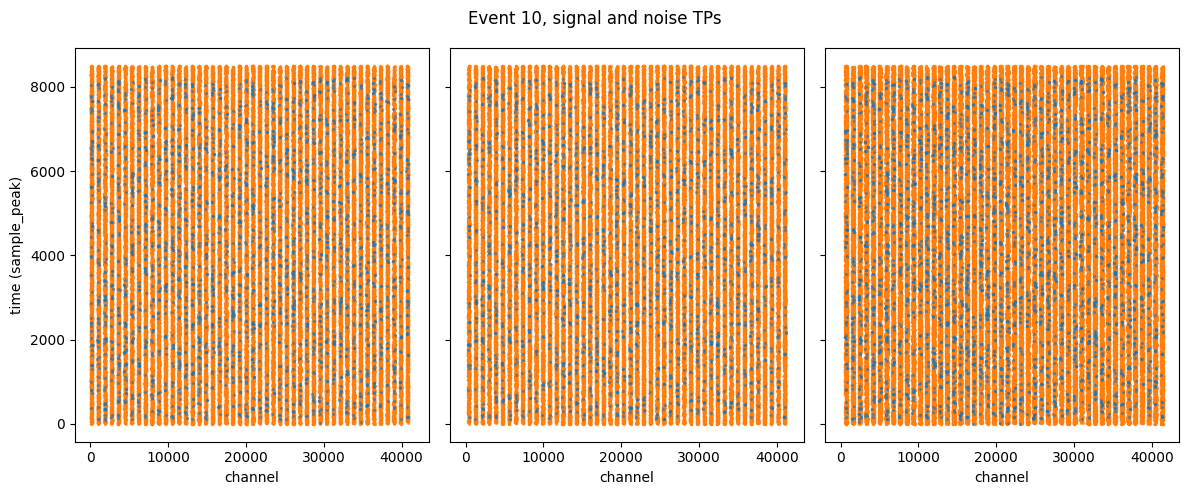

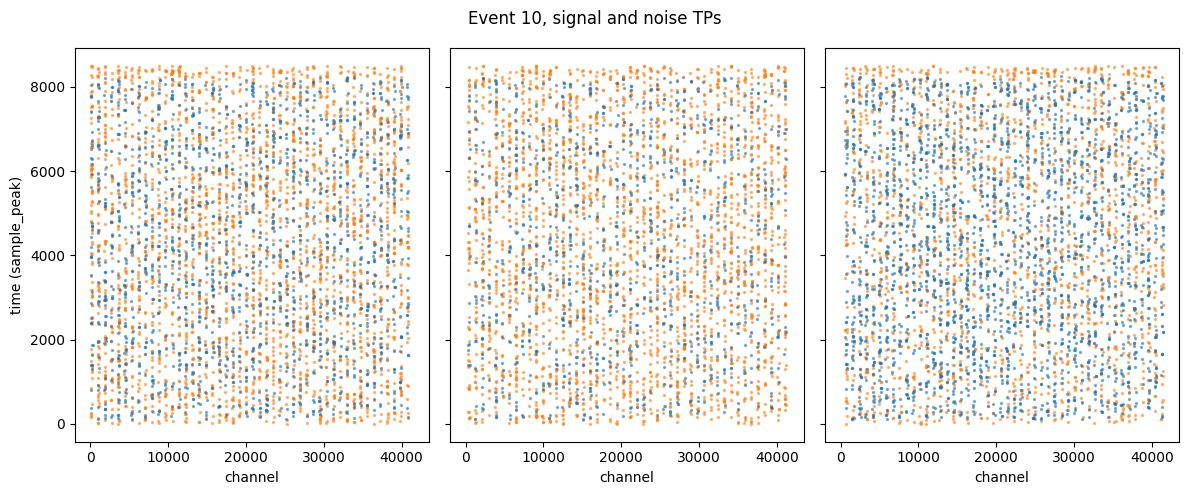

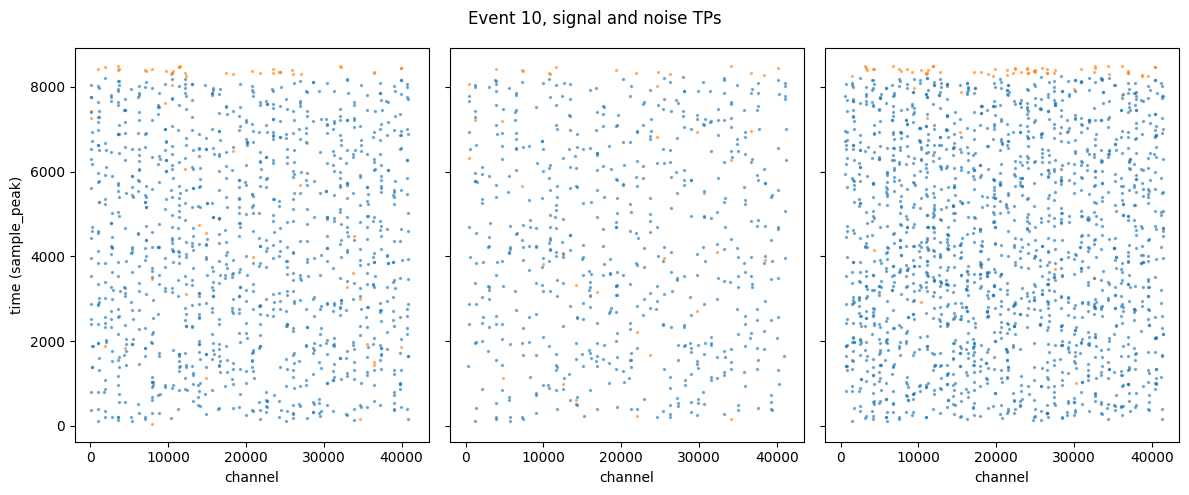

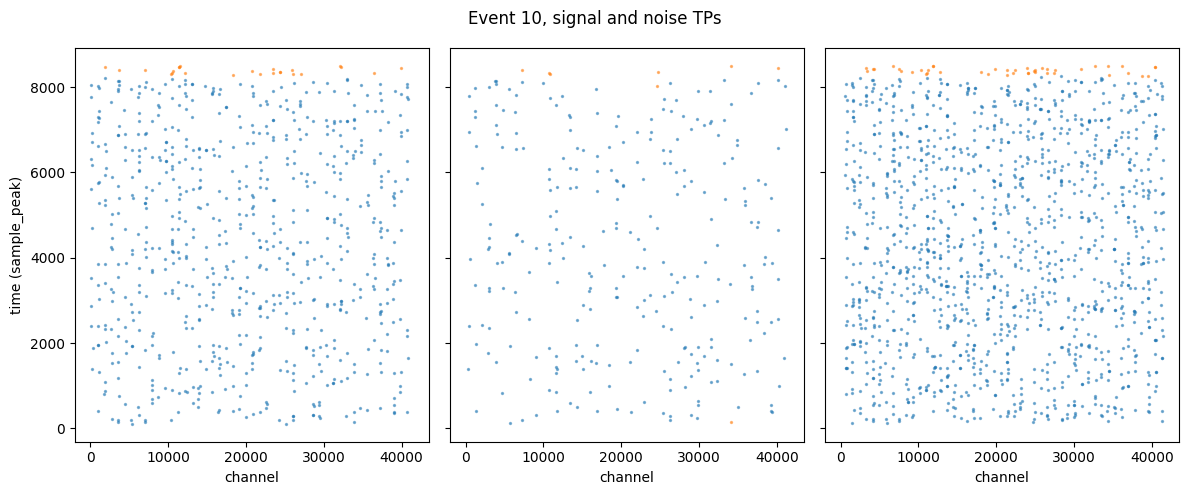

In [39]:
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 26'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 36'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 46'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 56'))
fig = x.draw_tp_event(10)


### Signal/Noise TP distribution in time - all events by plane

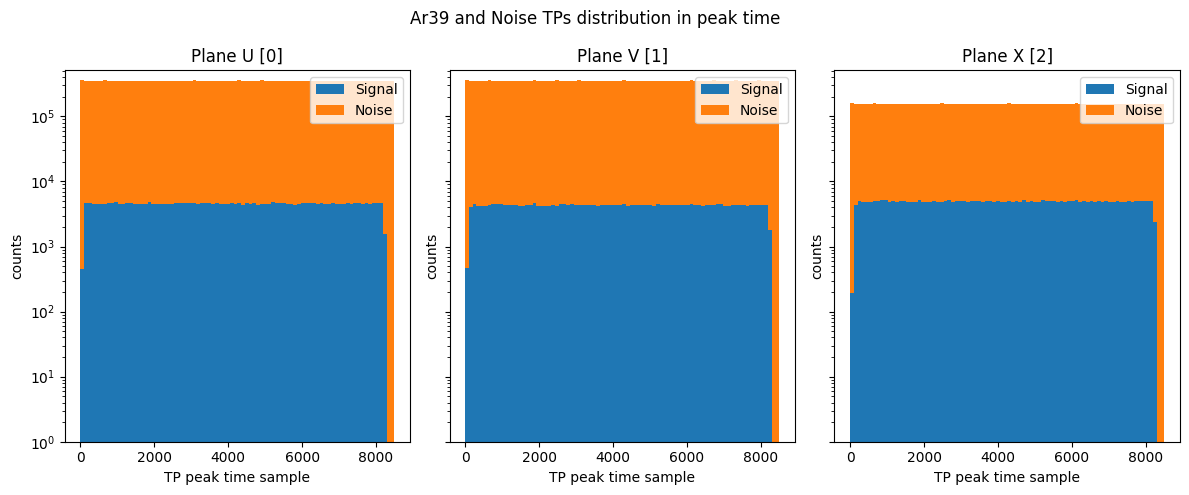

In [40]:
fig = alltp_ana.draw_tp_start_sample_dist()

<Axes: >

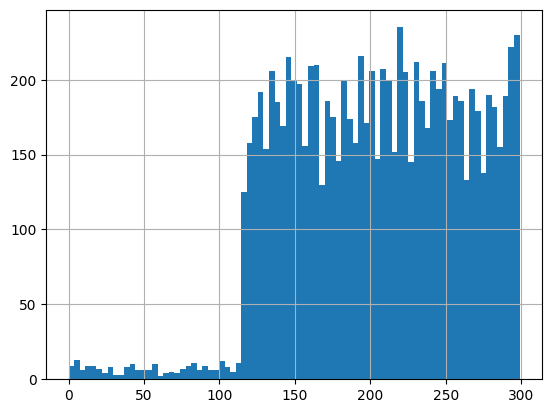

In [15]:
fig, axes = plt.subplots()
ax = axes
alltp_ana.tps.query("sample_start < 300").sig_view_2.sample_start.hist(ax=ax, bins=81)

# Cleaning: removing regions with uneven backtracking efficiency
Due to lack of IDEs

In [16]:
tpw = snn.TPSignalNoiseSelector(ws.tps[(ws.tps.sample_start >100) & (ws.tps.sample_start <8100)])
tp_ana = snn.TPSignalNoiseAnalyzer(tpw, signal_name='Ar39')

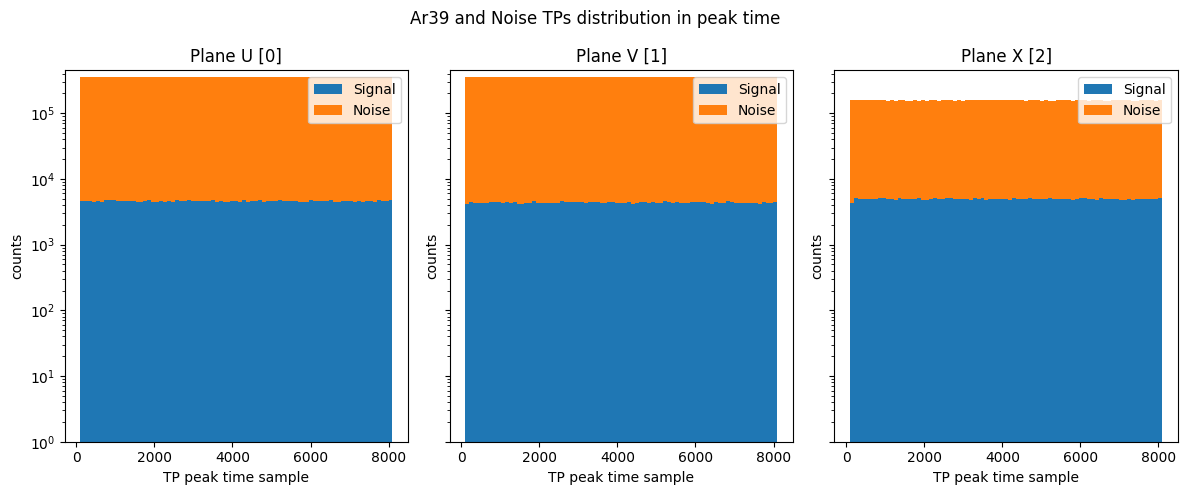

In [17]:
fig = tp_ana.draw_tp_start_sample_dist()


# adcpeak, time-over-threshold and SumADC distribution for Ar39 and noise

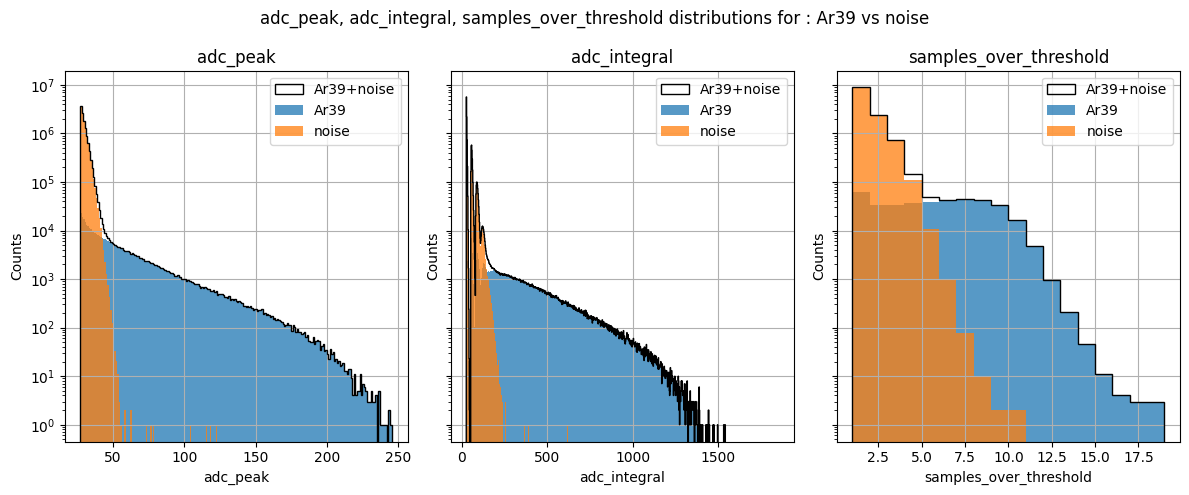

In [18]:
fig = tp_ana.draw_tp_signal_noise_dist()
fig.tight_layout()

# Signal distributions vs drift depth
### `adc_peak`, `adc_integral` and `signal_over_threshold` in bins of drift depth (20cm)

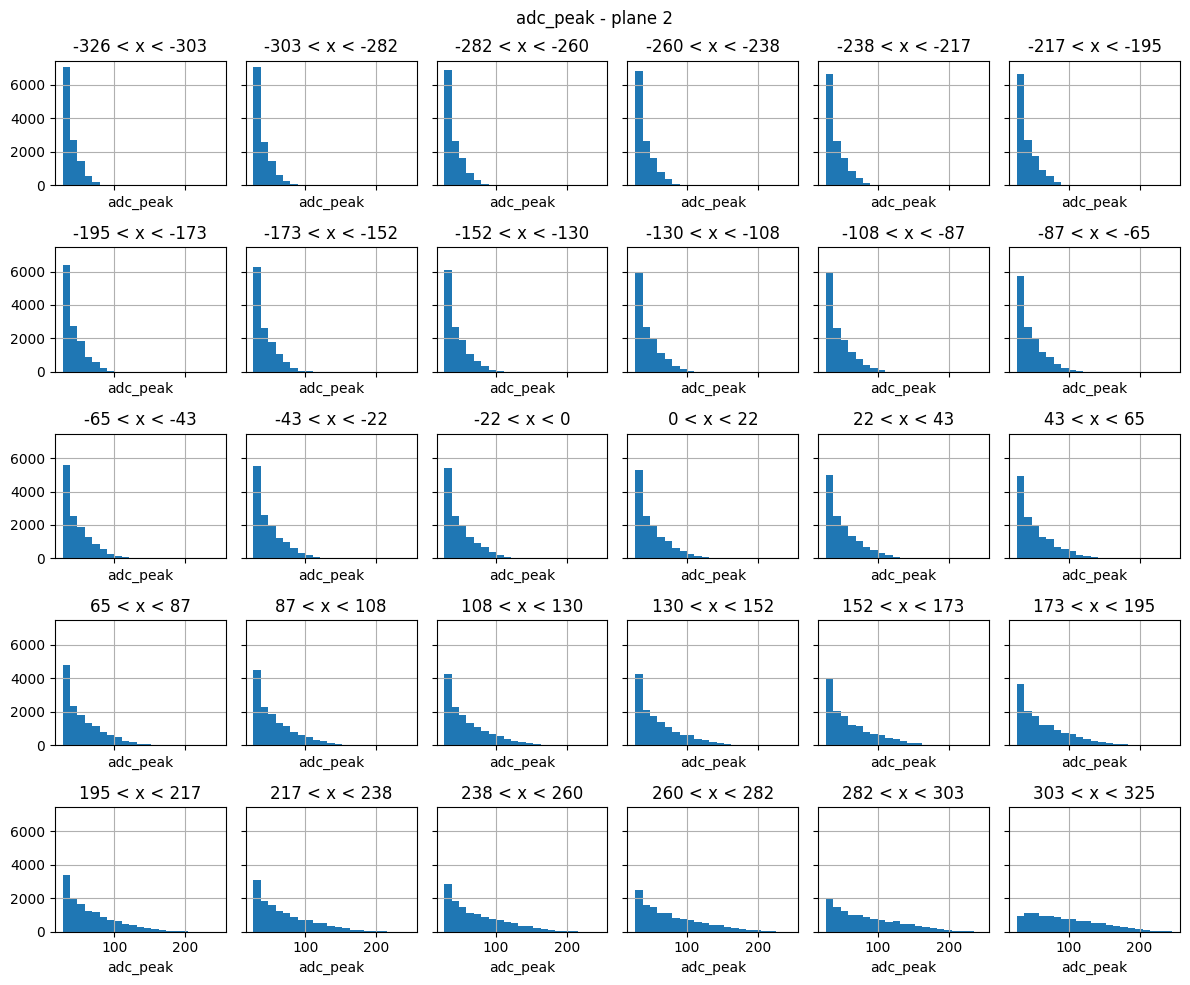

In [19]:
fig = tp_ana.draw_variable_in_drift_grid('adc_peak', downsampling=10, sharex=True, sharey=True, figsize=(12,10))
fig.tight_layout()

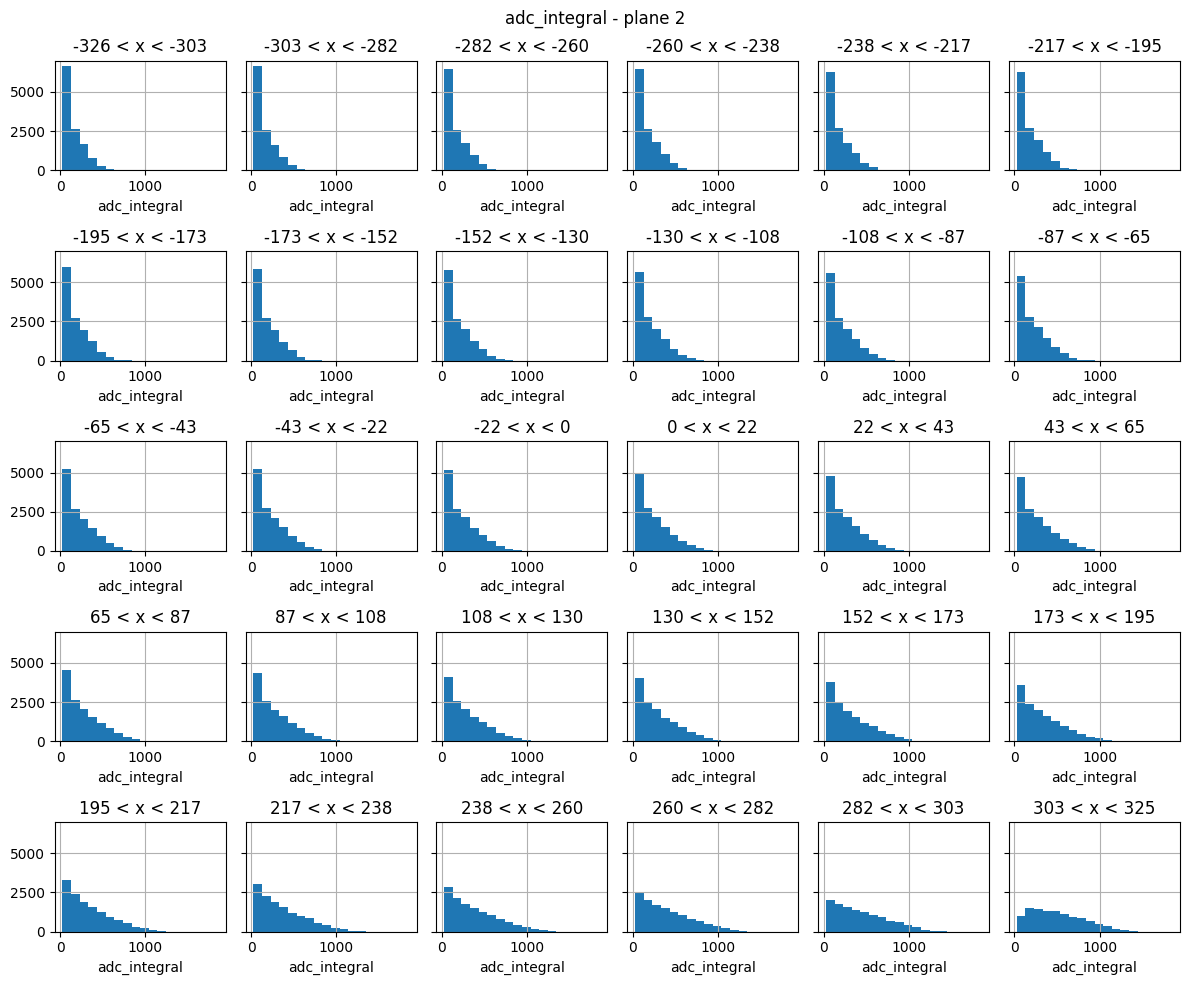

In [20]:
fig = tp_ana.draw_variable_in_drift_grid('adc_integral', downsampling=100, sharey=True, figsize=(12,10))
fig.tight_layout()

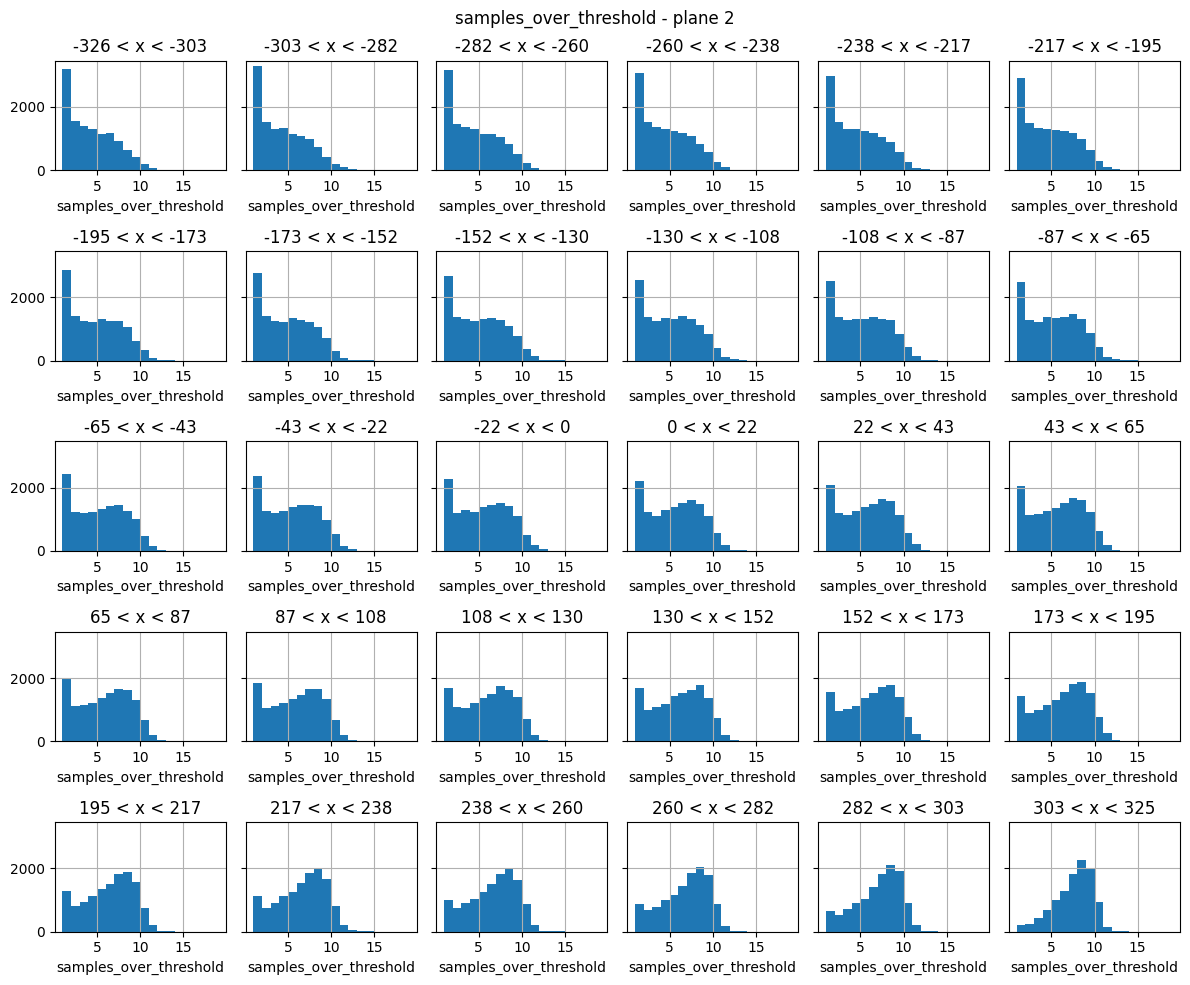

In [21]:
fig = tp_ana.draw_variable_in_drift_grid('samples_over_threshold', downsampling=1, log=False, sharey=True, figsize=(12,10))
fig.tight_layout()

### `adc_peak`, `adc_integral` and `signal_over_threshold` overlaied

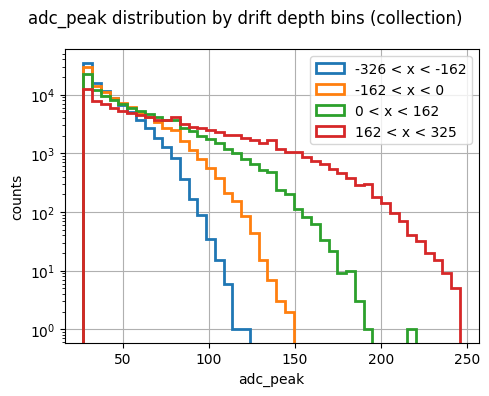

In [22]:
fig = tp_ana.draw_variable_drift_stack('adc_peak', downsampling=5, n_x_bins=4, log=True, figsize=(5,4))
fig.tight_layout()

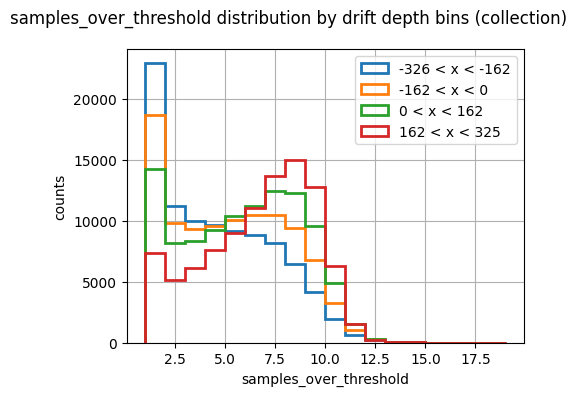

In [23]:
fig = tp_ana.draw_variable_drift_stack('samples_over_threshold', downsampling=1, n_x_bins=4, log=False, figsize=(5,4))
fig.tight_layout()


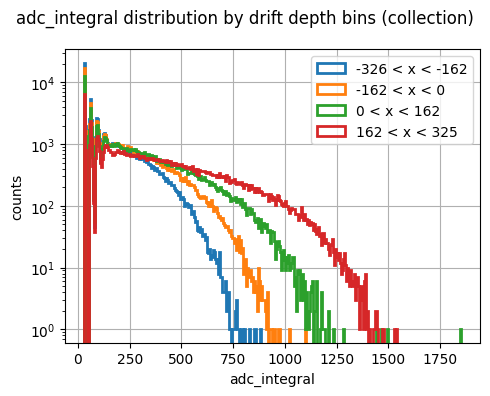

In [24]:
fig = tp_ana.draw_variable_drift_stack('adc_integral', downsampling=5, n_x_bins=4, log=True, figsize=(5,4))
fig.tight_layout()


# Effect of cuts on TP variables distributions

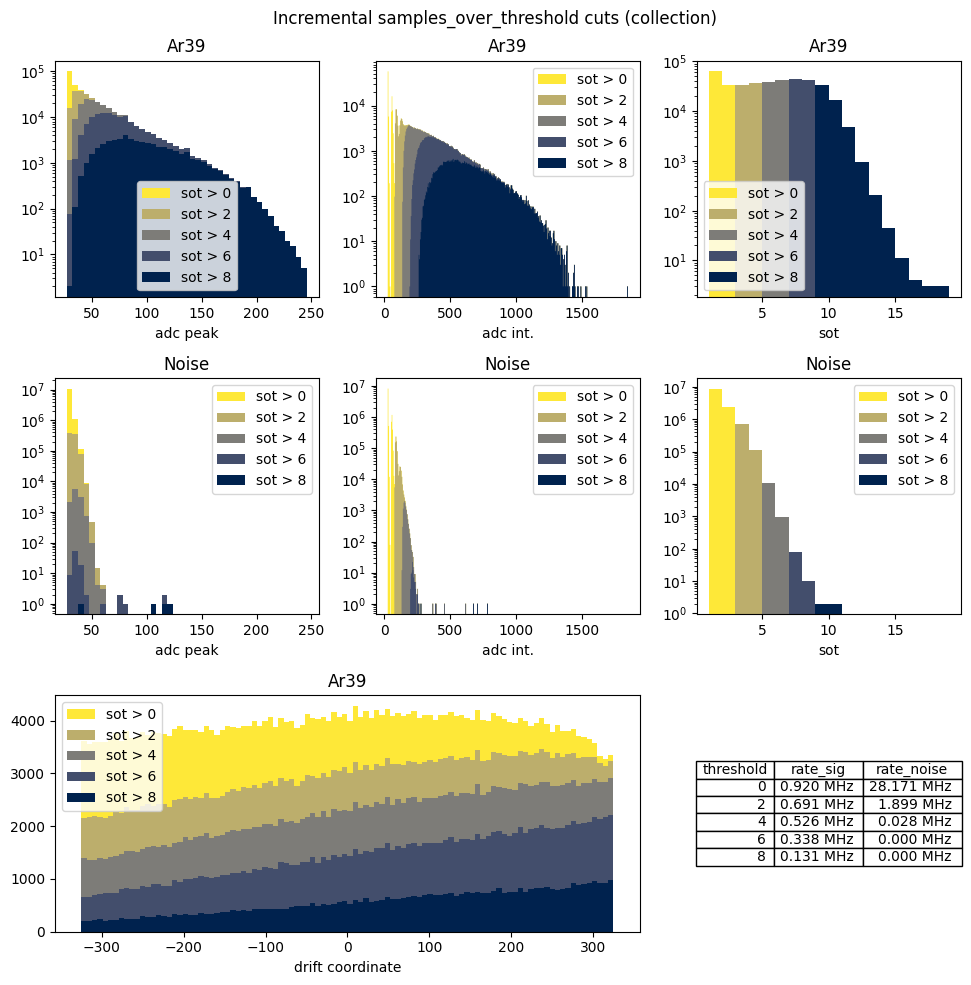

In [25]:
tot_cuts = [t for t in range(0,10,2)]

fig = tp_ana.draw_variable_cut_sequence('samples_over_threshold', tot_cuts, log=True, figsize=(10,10))


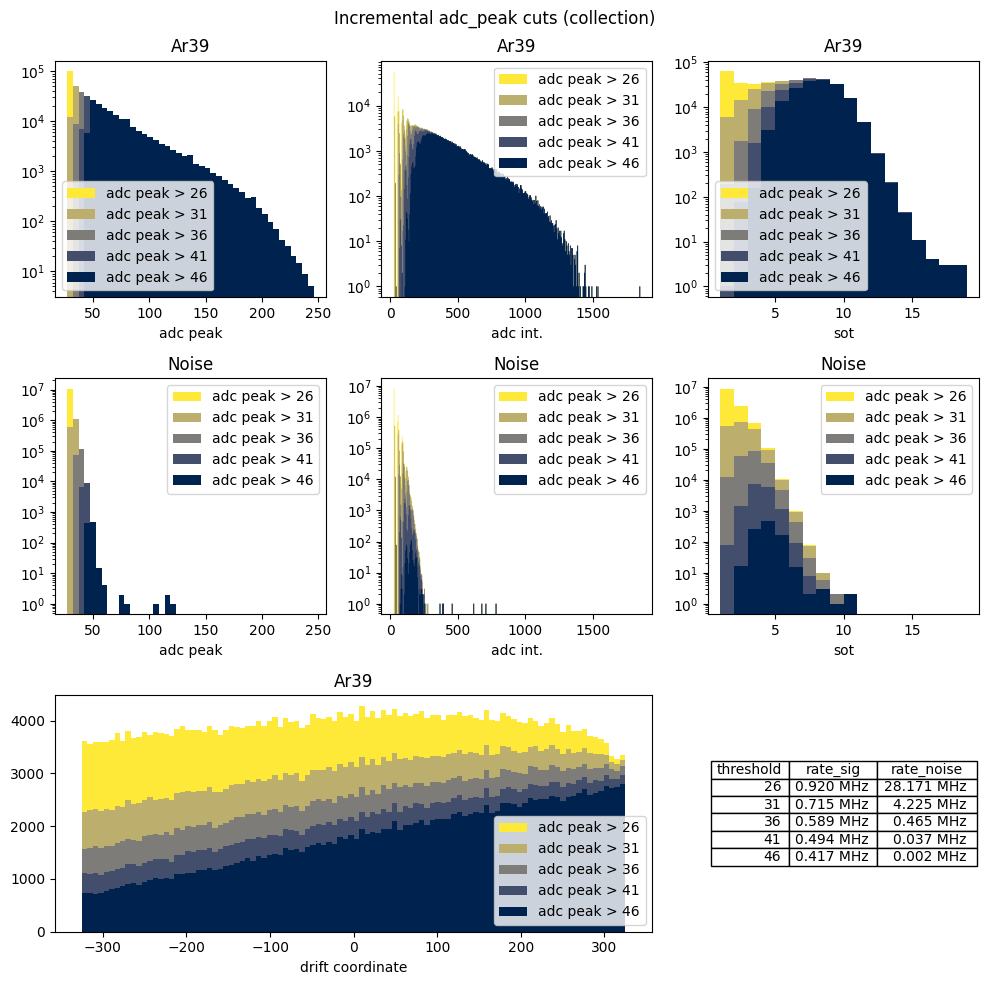

In [26]:
cuts = [t for t in range(26, 50, 5)]

fig = tp_ana.draw_variable_cut_sequence('adc_peak', cuts, log=True, figsize=(10,10))
fig.tight_layout()

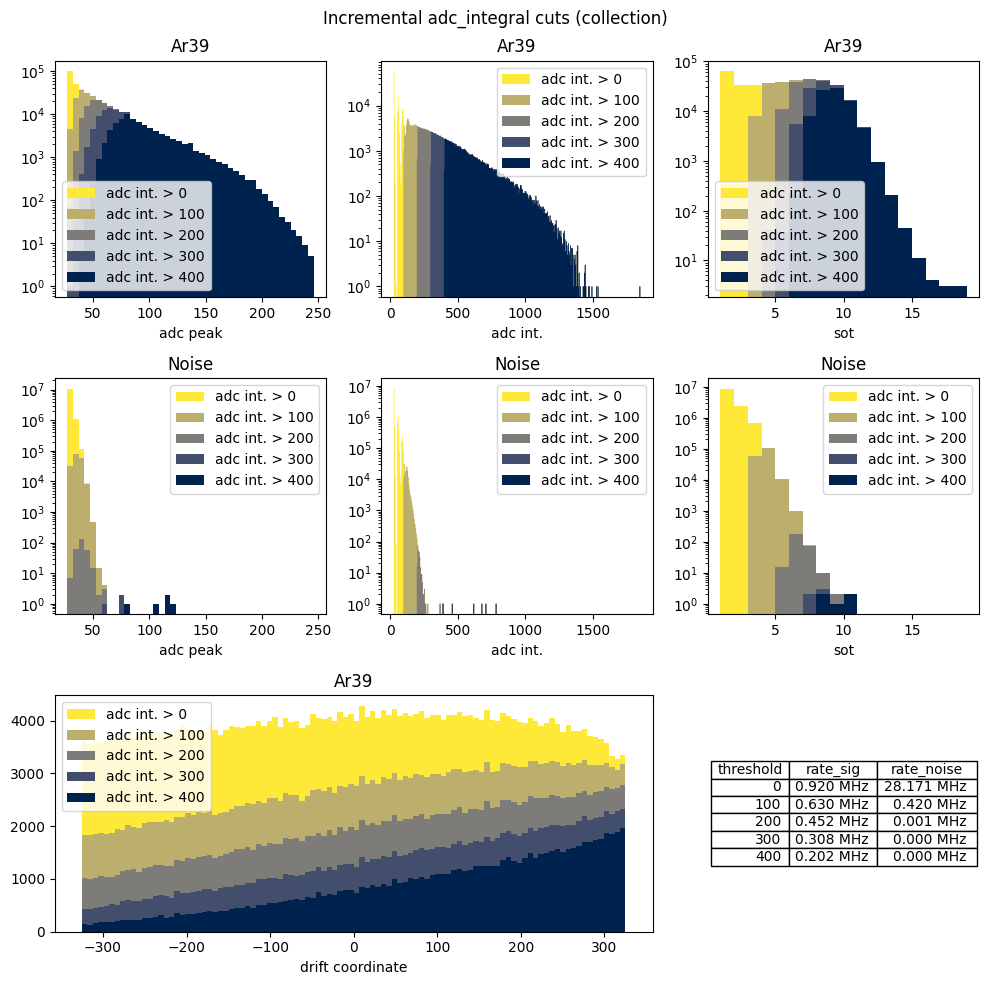

In [27]:
cuts = [t for t in range(0, 500, 100)]

fig = tp_ana.draw_variable_cut_sequence('adc_integral', cuts, figsize=(10,10), log=True)
fig.tight_layout()

## Threshold scans

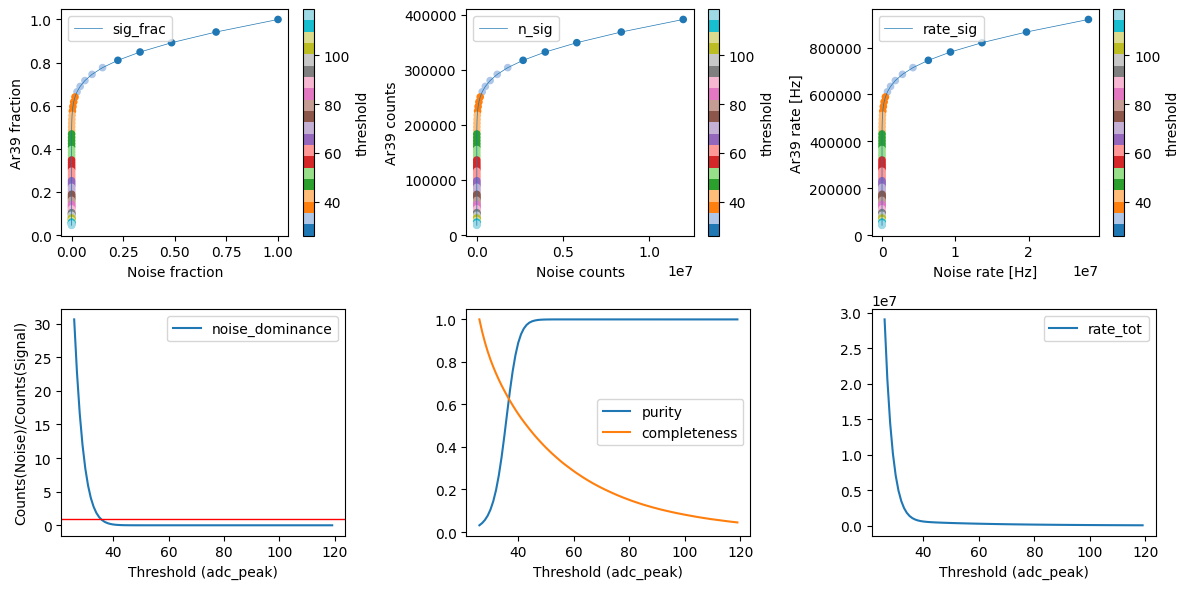

In [28]:
thresholds = [t for t in range(26, 120, 1)]

fig = tp_ana.draw_threshold_scan('adc_peak', thresholds)
fig.tight_layout()

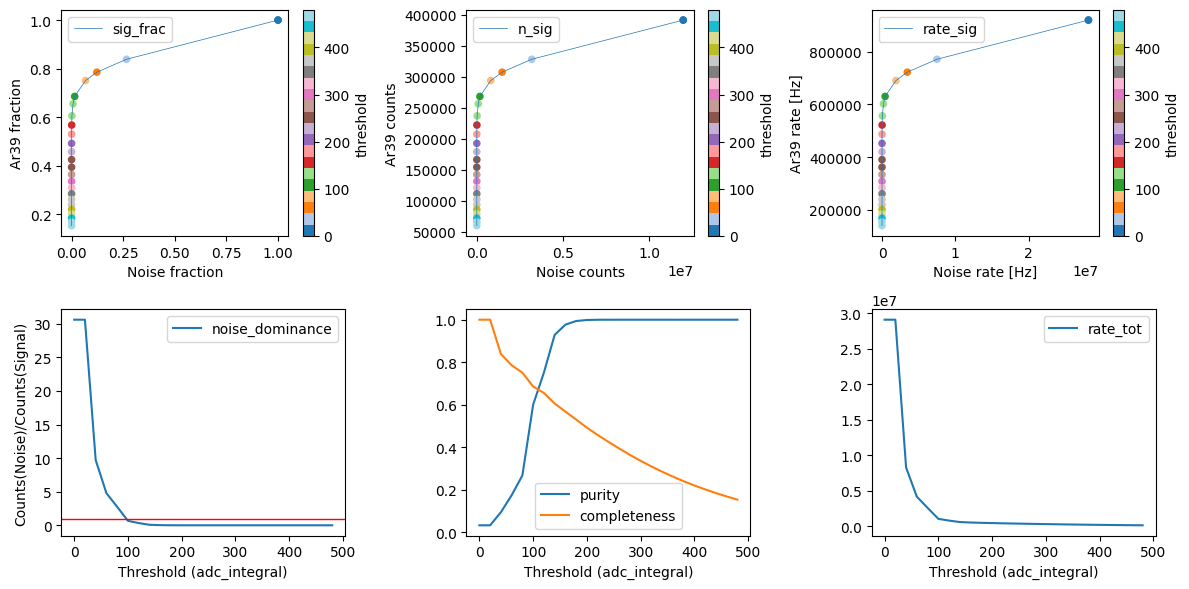

In [29]:
thresholds = [t for t in range(0, 500, 20)]

fig = tp_ana.draw_threshold_scan('adc_integral', thresholds)
fig.tight_layout()

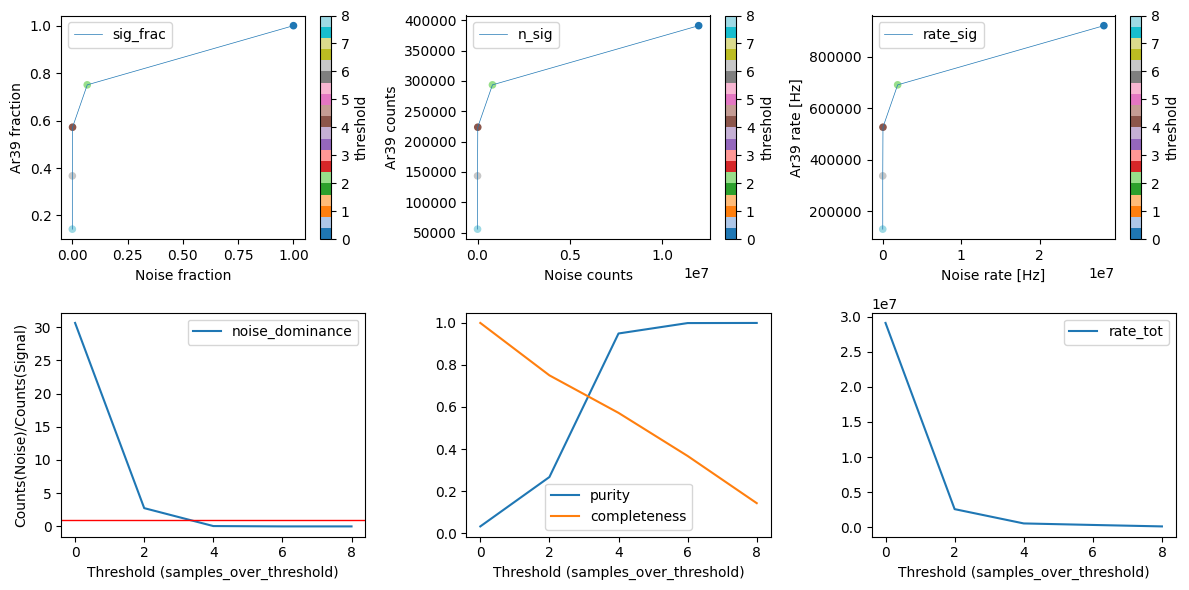

In [30]:
thresholds = [t for t in range(0,10,2)]

fig = tp_ana.draw_threshold_scan('samples_over_threshold', thresholds)
fig.tight_layout()

# Backtracking efficiency

Text(0.5, 0.98, 'adc_peak > 45')

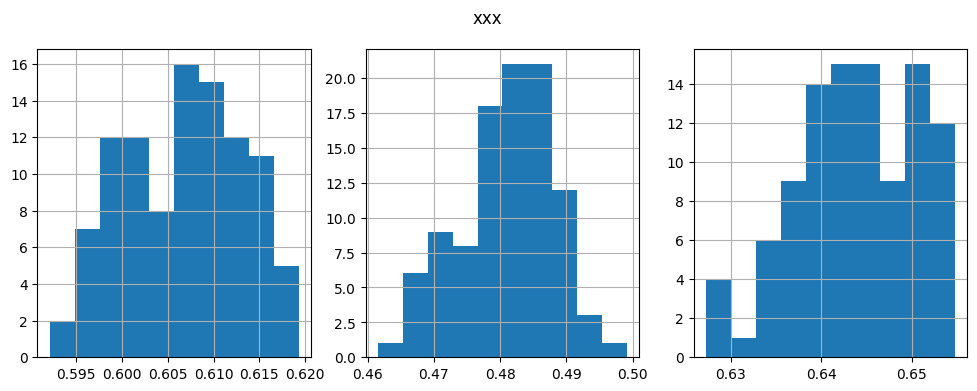

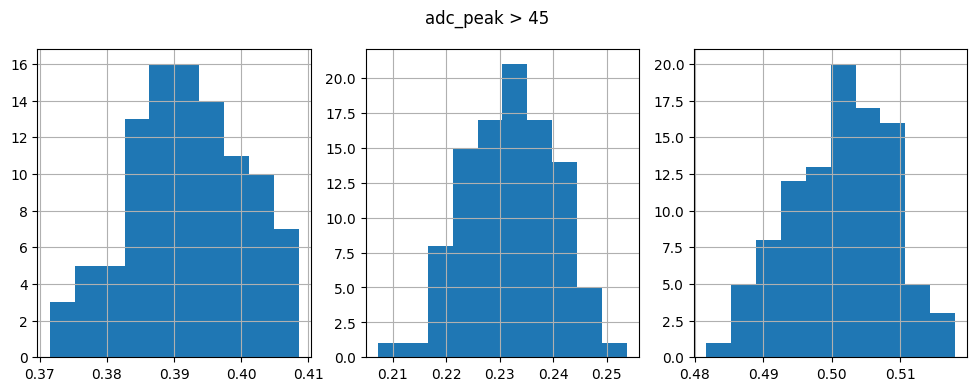

In [31]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
em_0_df = draw_bt_eff_by_plane(ws, 0, axes[0])
em_1_df = draw_bt_eff_by_plane(ws, 1, axes[1])
em_2_df = draw_bt_eff_by_plane(ws, 2, axes[2])
fig.suptitle('xxx')


filter='adc_peak > 45'
fig, axes = plt.subplots(1,3, figsize=(12,4))
em_0_df = draw_bt_eff_by_plane(ws, 0, axes[0], filter)
em_1_df = draw_bt_eff_by_plane(ws, 1, axes[1], filter)
em_2_df = draw_bt_eff_by_plane(ws, 2, axes[2], filter)
fig.suptitle(filter)

# Investigating weird TP and IDES distributions

In [42]:
weird_ides = ws.ides[ws.ides.timestamp > 8500]
display(weird_ides)
first_ides = ws.ides[ws.ides.timestamp < 100]
display(first_ides)


event       run  subrun  channel  timestamp  numelectrons    energy  \
466           1  20000047       0      108      65350    247.365677  0.012571   
467           1  20000047       0      108      65350    119.060219  0.010584   
468           1  20000047       0      108      65351   2060.005859  0.104692   
469           1  20000047       0      108      65351    731.576538  0.065032   
470           1  20000047       0      108      65352    726.811401  0.036937   
...         ...       ...     ...      ...        ...           ...       ...   
31180072    100  20000047       0    41427      65246     52.605354  0.003962   
31180073    100  20000047       0    41427      65247     51.393204  0.003870   
31180074    100  20000047       0    41427      65248     27.895889  0.002101   
31180075    100  20000047       0    41427      65249      8.403118  0.000633   
31180076    100  20000047       0    41427      65250      1.401907  0.000106   

                   x           y           z  trackID  origTrackID  \
466       276.644745 -659.078369  143.752151    13338         -999   
467       276.652069 -659.084656  143.750198    13338         -999   
468       276.644745 -659.078369  143.752151    13338         -999   
469       276.652069 -659.084656  143.750198    13338         -999   
470       276.644745 -659.078369  143.752151    13338         -999   
...              ...         ...         ...      ...          ...   
31180072   96.971237  593.558716  872.858215     6875         -999   
31180073   96.971237  593.558716  872.858215     6875         -999   
31180074   96.971237  593.558716  872.858215     6875         -999   
31180075   96.971237  593.558716  872.858215     6875         -999   
31180076   96.971237  593.558716  872.858215     6875         -999   

          readout_plane_id  readout_view  detector_element  
466                      0             0                 0  
467                      0             0                 0  
468                      0             0                 0  
469                      0             0                 0  
470                      0             0                 0  
...                    ...           ...               ...  
31180072                 2             2                47  
31180073                 2             2                47  
31180074                 2             2                47  
31180075                 2             2                47  
31180076                 2             2                47  

[3461739 rows x 15 columns]

event       run  subrun  channel  timestamp  numelectrons    energy  \
605           1  20000047       0      131          3      1.620536  0.000209   
606           1  20000047       0      131          4      7.838993  0.001009   
607           1  20000047       0      131          5     25.072035  0.003228   
608           1  20000047       0      131          6     53.056206  0.006830   
609           1  20000047       0      131          7     74.318878  0.009567   
...         ...       ...     ...      ...        ...           ...       ...   
31180034    100  20000047       0    41420          3     11.216750  0.000727   
31180043    100  20000047       0    41421          0   1129.979492  0.072480   
31180044    100  20000047       0    41421          1    252.726990  0.016226   
31180045    100  20000047       0    41421          2     76.460922  0.004912   
31180046    100  20000047       0    41421          3     14.054015  0.000903   

                  x           y           z  trackID  origTrackID  \
605        3.332465 -639.864807  145.933273    14739         -999   
606        3.332465 -639.864807  145.933273    14739         -999   
607        3.332465 -639.864807  145.933273    14739         -999   
608        3.332465 -639.864807  145.933273    14739         -999   
609        3.332465 -639.864807  145.933273    14739         -999   
...             ...         ...         ...      ...          ...   
31180034  56.360992  659.764404  870.033447     8649         -999   
31180043  56.361008  659.764221  870.033569     8649         -999   
31180044  56.361004  659.764221  870.033569     8649         -999   
31180045  56.361004  659.764221  870.033569     8649         -999   
31180046  56.361004  659.764221  870.033569     8649         -999   

          readout_plane_id  readout_view  detector_element  
605                      0             0                 0  
606                      0             0                 0  
607                      0             0                 0  
608                      0             0                 0  
609                      0             0                 0  
...                    ...           ...               ...  
31180034                 2             2                47  
31180043                 2             2                47  
31180044                 2             2                47  
31180045                 2             2                47  
31180046                 2             2                47  

[344887 rows x 15 columns]

In [ ]:
from tpvalidator.mcprod.backtracker import BackTrackerPlotter

In [ ]:
bt = BackTrackerPlotter(ws, 1)

[1]

1

/Users/ale/Development/dune/trigger-studies/tpvalidator/src/tpvalidator/mcprod/workspace.py:380: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
tps_ev1 = tpw.query('event==1')
display(tps_ev1.p2)

event       run  subrun  version  flag  detid  channel  \
12048       1  20000047       0        2     0      3      572   
12049       1  20000047       0        2     0      3      572   
12050       1  20000047       0        2     0      3      572   
12051       1  20000047       0        2     0      3      572   
12052       1  20000047       0        2     0      3      572   
...       ...       ...     ...      ...   ...    ...      ...   
721190      1  20000047       0        2     0      3    41471   
721191      1  20000047       0        2     0      3    41471   
721192      1  20000047       0        2     0      3    41471   
721193      1  20000047       0        2     0      3    41471   
721194      1  20000047       0        2     0      3    41471   

        samples_over_threshold  time_start  samples_to_peak  ...  \
12048                        1       28352                0  ...   
12049                        1       62912                0  ...   
12050                        2       89440                0  ...   
12051                        1      123232                0  ...   
12052                        2      136864                0  ...   
...                        ...         ...              ...  ...   
721190                       1      217600                0  ...   
721191                       1      222880                0  ...   
721192                       1      237536                0  ...   
721193                       1      241856                0  ...   
721194                       2      251808                0  ...   

                bt_z  bt_primary_x  bt_primary_y  bt_primary_z  \
12048  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12049  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12050  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12051  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12052  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
...              ...           ...           ...           ...   
721190 -99999.000000 -99999.000000 -99999.000000 -99999.000000   
721191 -99999.000000 -99999.000000 -99999.000000 -99999.000000   
721192 -99999.000000 -99999.000000 -99999.000000 -99999.000000   
721193    896.014648   -182.265442    624.720398    896.014648   
721194 -99999.000000 -99999.000000 -99999.000000 -99999.000000   

        bt_truth_block_id  bt_generator_name  time_peak  sample_start  \
12048              -99999                         28384           886   
12049              -99999                         62944          1966   
12050              -99999                         89504          2795   
12051              -99999                        123264          3851   
12052              -99999                        136928          4277   
...                   ...                ...        ...           ...   
721190             -99999                        217632          6800   
721191             -99999                        222912          6965   
721192             -99999                        237568          7423   
721193                  0       Ar39GenInLAr     241888          7558   
721194             -99999                        251872          7869   

        sample_peak  bt_is_signal  
12048           887         False  
12049          1967         False  
12050          2797         False  
12051          3852         False  
12052          4279         False  
...             ...           ...  
721190         6801         False  
721191         6966         False  
721192         7424         False  
721193         7559          True  
721194         7871         False  

[121679 rows x 32 columns]

In [ ]:
tps_ev1.p2.query("adc_peak >48 & bt_is_signal == 0 ")

event       run  subrun  version  flag  detid  channel  \
284846      1  20000047       0        2     0      3    16229   
346285      1  20000047       0        2     0      3    19852   

        samples_over_threshold  time_start  samples_to_peak  ...     bt_z  \
284846                       3      127232                1  ... -99999.0   
346285                       4       41344                1  ... -99999.0   

        bt_primary_x  bt_primary_y  bt_primary_z  bt_truth_block_id  \
284846      -99999.0      -99999.0      -99999.0             -99999   
346285      -99999.0      -99999.0      -99999.0             -99999   

        bt_generator_name  time_peak  sample_start  sample_peak  bt_is_signal  
284846                        127328          3976         3979         False  
346285                         41472          1292         1296         False  

[2 rows x 32 columns]

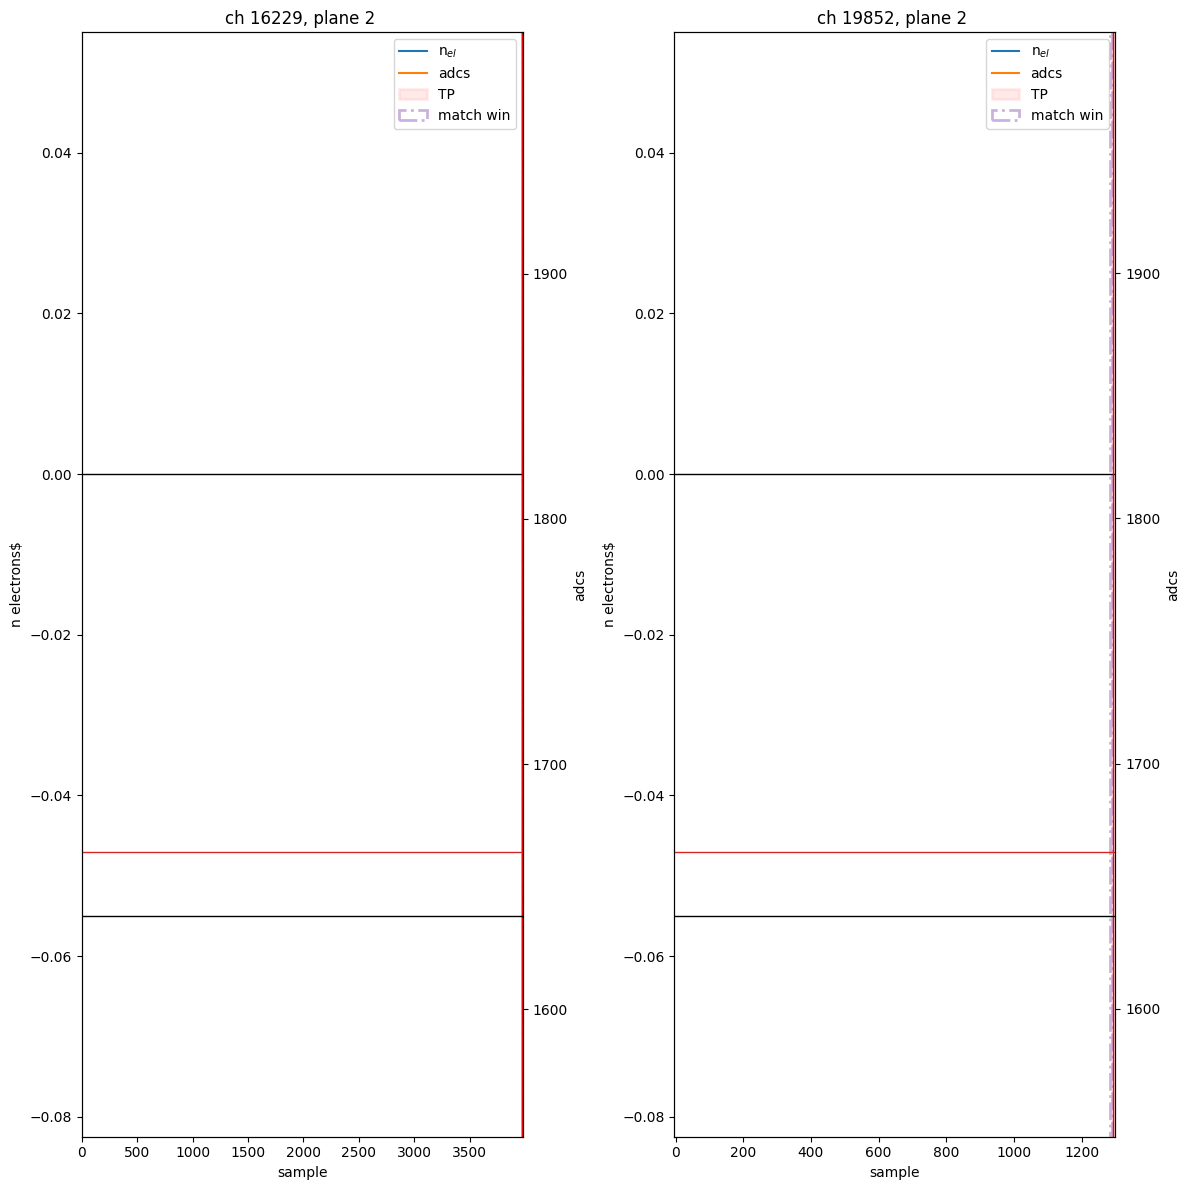

In [ ]:
bt.plot_tps_vs_ides(tps_ev1.p2.query("adc_peak >48 & bt_is_signal == 0 "), figsize=(12,12))


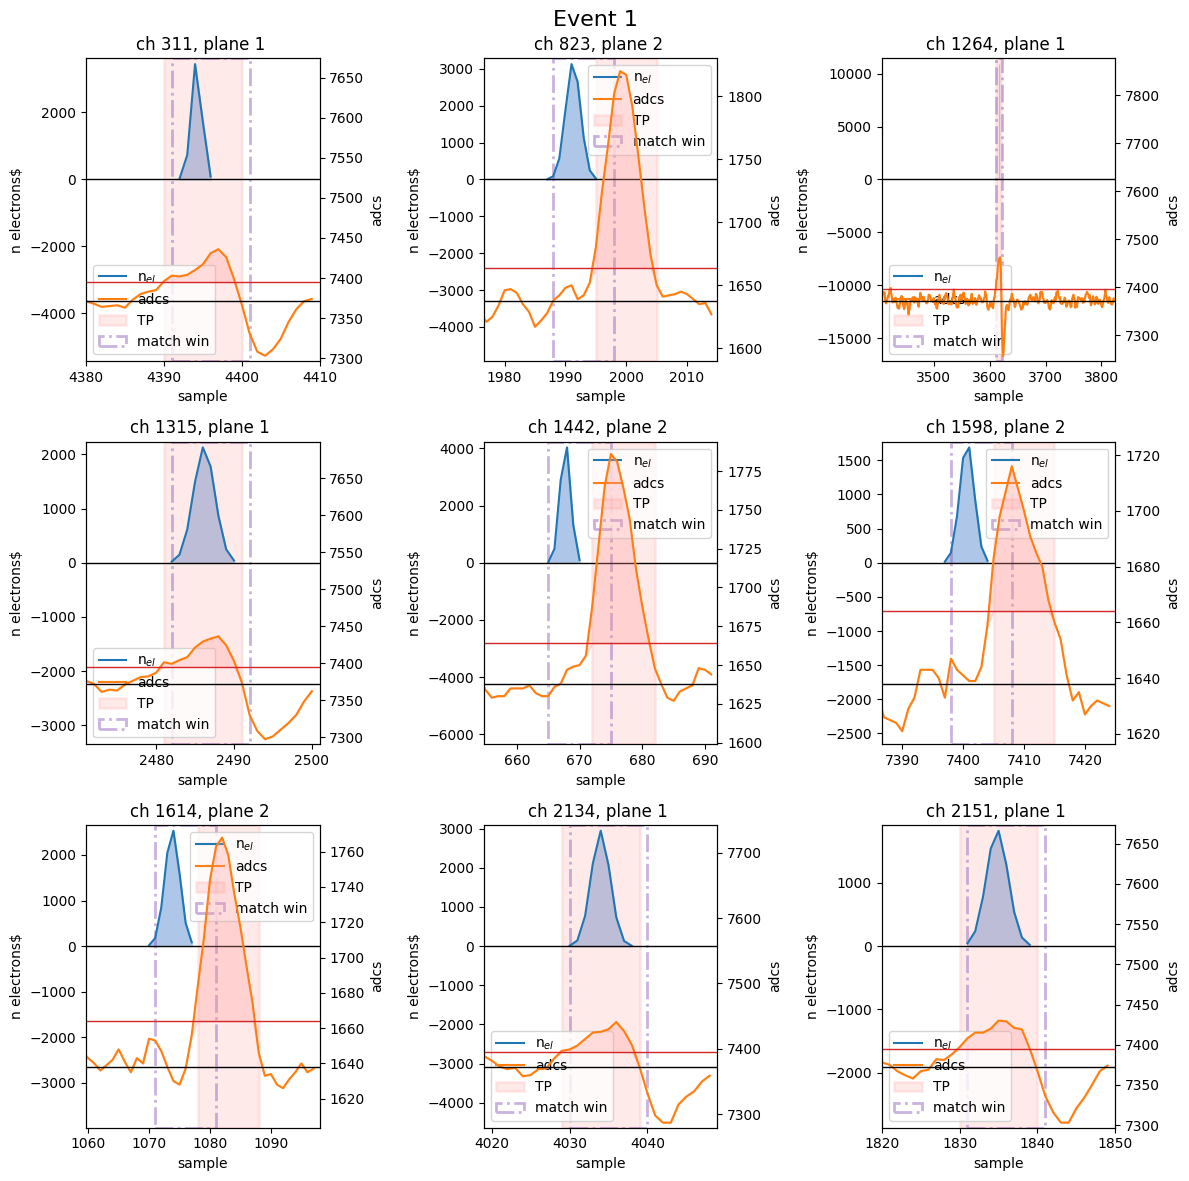

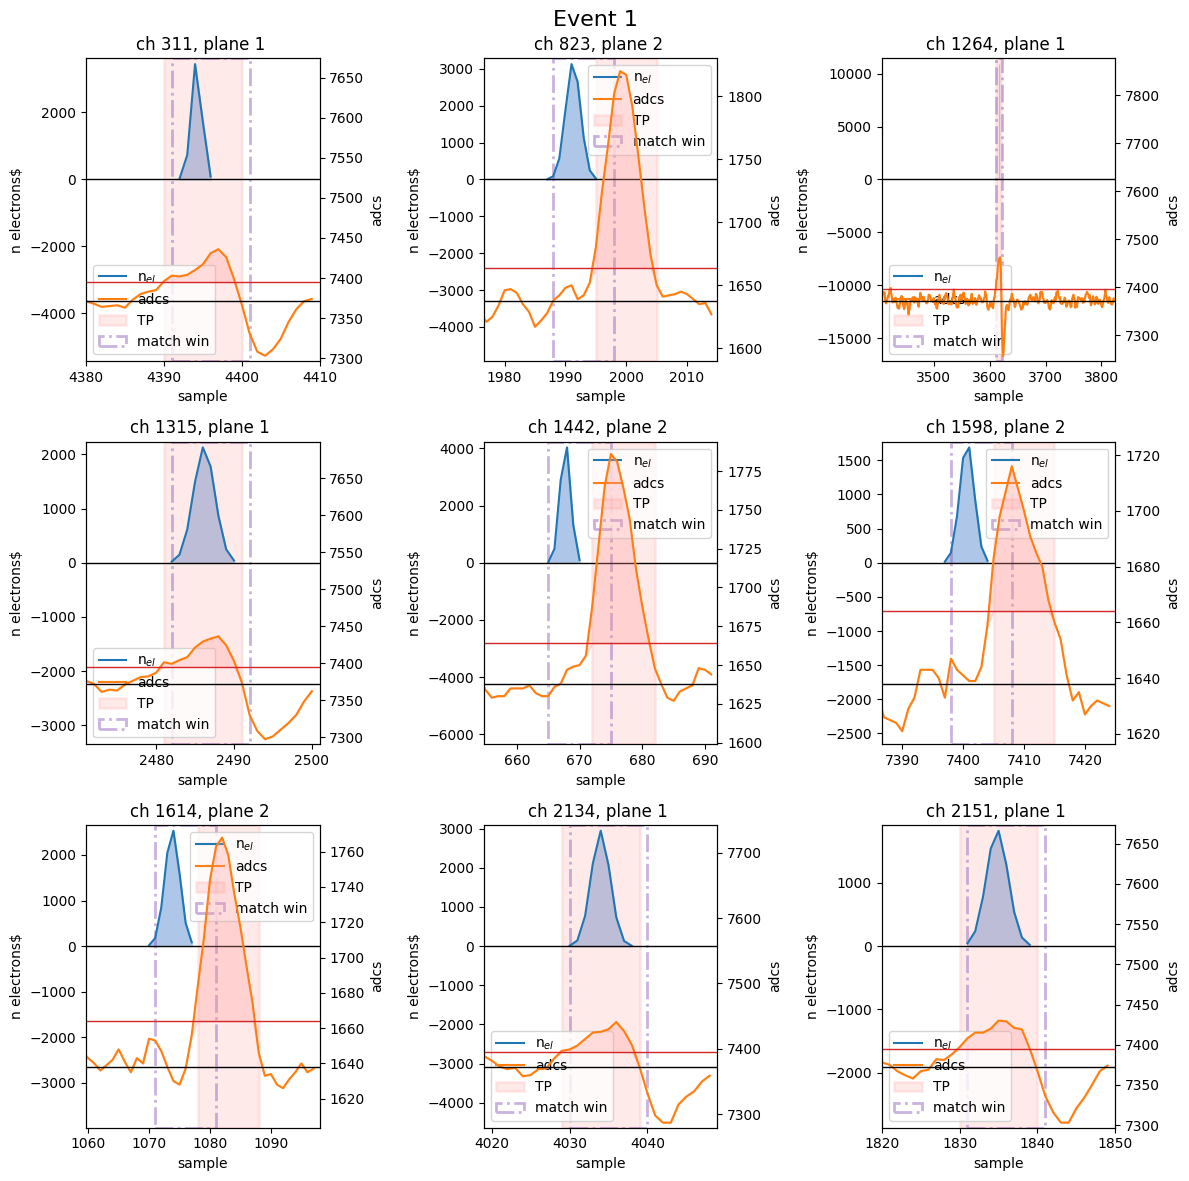

In [ ]:
bt.plot_tps_vs_ides(bt.inspect_tps.query('TP_TOT == 10').iloc[:9], figsize=(12,12))


# Impact of tighter adcpeak cuts

In [ ]:
tp_clean = tpw.query('adc_peak > 30')
tp_clean_ana = snn.TPSignalNoiseAnalyzer(tp_clean, readout_window=8000)

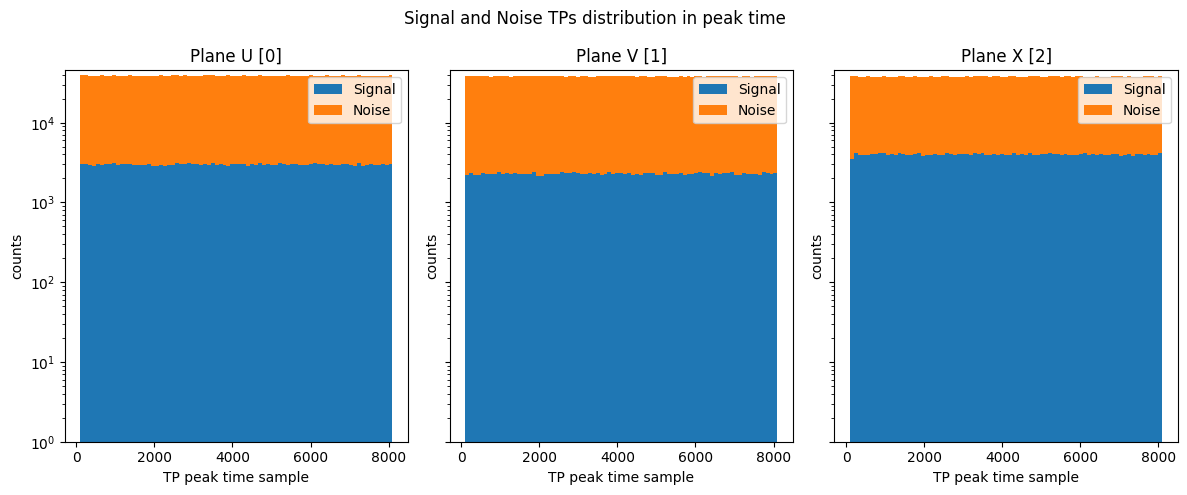

In [ ]:
fig = tp_clean_ana.draw_tp_start_sample_dist()


In [ ]:
simulated_time = len(tp_clean.all.event.unique())*8000*0.5e-6
df_scan = tp_clean_ana.do_threshold_scan(2, 'adc_peak', [35, 38, 40, 41, 42, 44, 46])
display(df_scan)

threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         35  259832   314981  649580.0    787452.5  574813  1437032.5   
1         38  233016    75059  582540.0    187647.5  308075   770187.5   
2         40  217143    26863  542857.5     67157.5  244006   610015.0   
3         41  209768    15829  524420.0     39572.5  225597   563992.5   
4         42  202835     9196  507087.5     22990.0  212031   530077.5   
5         44  189617     2959  474042.5      7397.5  192576   481440.0   
6         46  177210      922  443025.0      2305.0  178132   445330.0   

   sig_frac  noise_frac  
0  0.819827    0.117284  
1  0.735217    0.027948  
2  0.685134    0.010002  
3  0.661864    0.005894  
4  0.639989    0.003424  
5  0.598284    0.001102  
6  0.559137    0.000343

In [ ]:
df_scan['noise_rate_per_chan'] = df_scan.n_noise/simulated_time/14016
display(df_scan)

threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         35  259832   314981  649580.0    787452.5  574813  1437032.5   
1         38  233016    75059  582540.0    187647.5  308075   770187.5   
2         40  217143    26863  542857.5     67157.5  244006   610015.0   
3         41  209768    15829  524420.0     39572.5  225597   563992.5   
4         42  202835     9196  507087.5     22990.0  212031   530077.5   
5         44  189617     2959  474042.5      7397.5  192576   481440.0   
6         46  177210      922  443025.0      2305.0  178132   445330.0   

   sig_frac  noise_frac  noise_rate_per_chan  
0  0.819827    0.117284            56.182399  
1  0.735217    0.027948            13.388092  
2  0.685134    0.010002             4.791488  
3  0.661864    0.005894             2.823380  
4  0.639989    0.003424             1.640268  
5  0.598284    0.001102             0.527790  
6  0.559137    0.000343             0.164455

In [ ]:
df_scan = tp_clean_ana.do_threshold_scan(0, 'adc_peak', [34, 35, 38, 40, 41, 42, 44, 46, 48])
df_scan['noise_rate_per_chan'] = df_scan.n_noise/simulated_time/13278
display(df_scan)


threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         34  192909   620508  482272.5   1551270.0  813417  2033542.5   
1         35  183612   413940  459030.0   1034850.0  597552  1493880.0   
2         38  159122   114908  397805.0    287270.0  274030   685075.0   
3         40  144802    46606  362005.0    116515.0  191408   478520.0   
4         41  138236    29094  345590.0     72735.0  167330   418325.0   
5         42  132120    17993  330300.0     44982.5  150113   375282.5   
6         44  120454     6787  301135.0     16967.5  127241   318102.5   
7         46  109754     2578  274385.0      6445.0  112332   280830.0   
8         48  100302     1000  250755.0      2500.0  101302   253255.0   

   sig_frac  noise_frac  noise_rate_per_chan  
0  0.815414    0.218795           116.830095  
1  0.776116    0.145958            77.937189  
2  0.672598    0.040517            21.635035  
3  0.612069    0.016434             8.775041  
4  0.584315    0.010259             5.477858  
5  0.558463    0.006344             3.387747  
6  0.509151    0.002393             1.277866  
7  0.463923    0.000909             0.485389  
8  0.423970    0.000353             0.188281

In [ ]:
df_scan = tp_clean_ana.do_threshold_scan(1, 'adc_peak', [34, 35, 38, 40, 41, 42, 44, 46, 48])
df_scan['noise_rate_per_chan'] = df_scan.n_noise/simulated_time/13278
display(df_scan)


threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         34  132808   621787  332020.0   1554467.5  754595  1886487.5   
1         35  123189   414717  307972.5   1036792.5  537906  1344765.0   
2         38   99090   115984  247725.0    289960.0  215074   537685.0   
3         40   85886    47017  214715.0    117542.5  132903   332257.5   
4         41   79938    29605  199845.0     74012.5  109543   273857.5   
5         42   74276    18618  185690.0     46545.0   92894   232235.0   
6         44   64415     7190  161037.5     17975.0   71605   179012.5   
7         46   55729     2826  139322.5      7065.0   58555   146387.5   
8         48   48287     1261  120717.5      3152.5   49548   123870.0   

   sig_frac  noise_frac  noise_rate_per_chan  
0  0.732213    0.219028           117.070907  
1  0.679180    0.146086            78.083484  
2  0.546315    0.040856            21.837626  
3  0.473517    0.016562             8.852425  
4  0.440724    0.010429             5.574070  
5  0.409507    0.006558             3.505423  
6  0.355140    0.002533             1.353743  
7  0.307252    0.000995             0.532083  
8  0.266222    0.000444             0.237423